In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import re
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm 
from sklearn.linear_model import LinearRegression
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score,mean_squared_error
import warnings
warnings.filterwarnings('ignore')

Dataset characteristics
=========================================	
day.csv have the following fields:
	
	- instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

In [102]:
bike = pd.read_csv("day.csv")
bike.head()

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600

In [103]:
bike.shape

(730, 16)

In [104]:
data = bike[['season','yr','mnth', 'holiday', 'weekday','workingday', 'weathersit']]
for col in data:
    print(' '+col+':',data[col].unique(),'\n length of '+col+ ':',len(data[col].unique()))
    print()

 season: [1 2 3 4] 
 length of season: 4

 yr: [0 1] 
 length of yr: 2

 mnth: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
 length of mnth: 12

 holiday: [0 1] 
 length of holiday: 2

 weekday: [6 0 1 2 3 4 5] 
 length of weekday: 7

 workingday: [0 1] 
 length of workingday: 2

 weathersit: [2 1 3] 
 length of weathersit: 3



In [105]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [106]:
bike.describe()

instant      season          yr        mnth     holiday     weekday  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean   365.500000    2.498630    0.500000    6.526027    0.028767    2.997260   
std    210.877136    1.110184    0.500343    3.450215    0.167266    2.006161   
min      1.000000    1.000000    0.000000    1.000000    0.000000    0.000000   
25%    183.250000    2.000000    0.000000    4.000000    0.000000    1.000000   
50%    365.500000    3.000000    0.500000    7.000000    0.000000    3.000000   
75%    547.750000    3.000000    1.000000   10.000000    0.000000    5.000000   
max    730.000000    4.000000    1.000000   12.000000    1.000000    6.000000   

       workingday  weathersit        temp       atemp         hum   windspeed  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean     0.683562    1.394521   20.319259   23.726322   62.765175   12.763620   
std      0.465405    0.544807    7.506729    8.150308   14.237589    5.195841   
min      0.000000    1.000000    2.424346    3.953480    0.000000    1.500244   
25%      0.000000    1.000000   13.811885   16.889713   52.000000    9.041650   
50%      1.000000    1.000000   20.465826   24.368225   62.625000   12.125325   
75%      1.000000    2.000000   26.880615   30.445775   72.989575   15.625589   
max      1.000000    3.000000   35.328347   42.044800   97.250000   34.000021   

            casual   registered          cnt  
count   730.000000   730.000000   730.000000  
mean    849.249315  3658.757534  4508.006849  
std     686.479875  1559.758728  1936.011647  
min       2.000000    20.000000    22.000000  
25%     316.250000  2502.250000  3169.750000  
50%     717.000000  3664.500000  4548.500000  
75%    1096.500000  4783.250000  5966.000000  
max    3410.000000  6946.000000  8714.000000

In [107]:
bike.yr.value_counts()

0    365
1    365
Name: yr, dtype: int64

In [108]:
#bike['year'] = bike['dteday'].str.split('-').str[2]

In [22]:
bike.head()

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600

In [23]:
year_cnt = bike.groupby('yr')['cnt'].sum().reset_index(name='total_cnt')
year_cnt

yr  total_cnt
0   0    1243103
1   1    2047742

### Comparing to 2018, total number of bikes was increased in 2019

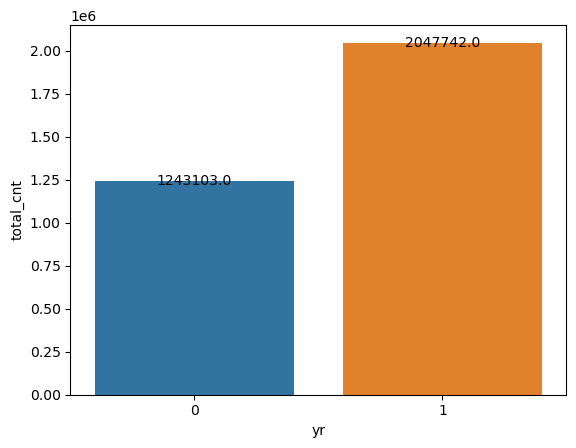

In [298]:
#create pie chart
# plt.pie(year_cnt.total_cnt, labels = year_cnt.yr, autopct='%.0f%%')
# plt.show()

ax = sns.barplot(x=year_cnt.yr, y=year_cnt['total_cnt'])
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center')
plt.show()

In [24]:
mnth_cnt = bike.groupby('mnth')['cnt'].sum().reset_index(name='total_cnt')
mnth_cnt

mnth  total_cnt
0      1     134933
1      2     149518
2      3     228920
3      4     269094
4      5     331686
5      6     346342
6      7     344948
7      8     351194
8      9     345991
9     10     322352
10    11     254831
11    12     211036

### The bike rent's count was increased from APR to Oct comparing to other month

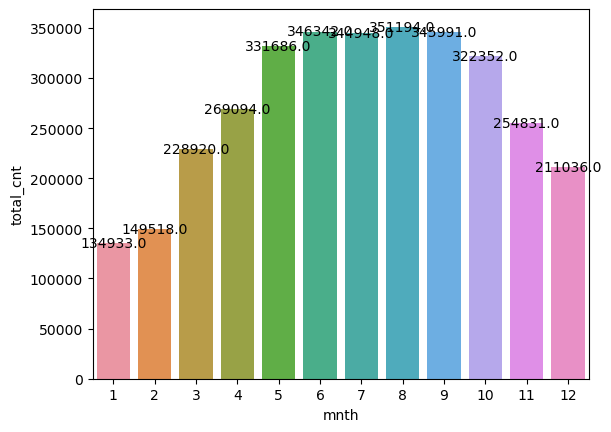

In [300]:
ax = sns.barplot(x=mnth_cnt.mnth, y=mnth_cnt['total_cnt'])
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center')
plt.show()

	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
### peoples are more likely to choose bike renatls in summer and fall, winter

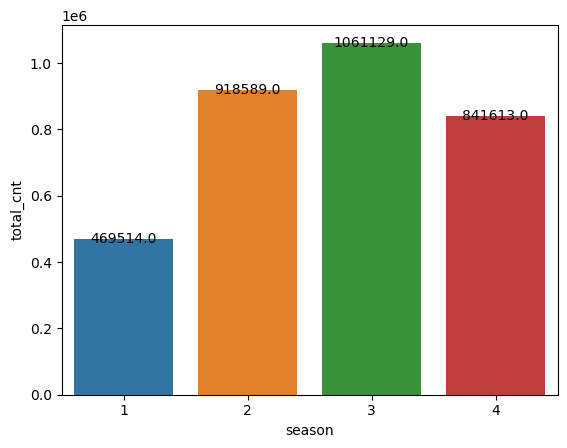

In [301]:
season_cnt = bike.groupby('season')['cnt'].sum().reset_index(name='total_cnt')
#print(workday_cnt)
ax = sns.barplot(x=season_cnt.season, y=season_cnt['total_cnt'])
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center')
plt.show()

+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
        
 ### peoples are interest to take rental bikes 1 And 2

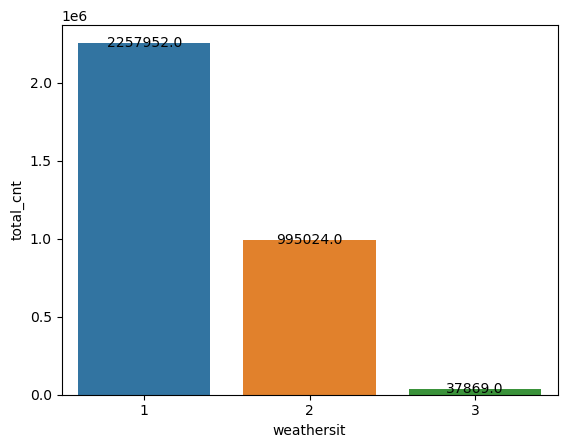

In [302]:
weathersit_cnt = bike.groupby('weathersit')['cnt'].sum().reset_index(name='total_cnt')
#print(workday_cnt)
ax = sns.barplot(x=weathersit_cnt.weathersit, y=weathersit_cnt['total_cnt'])
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center')
plt.show()

### Peoples are more interested to take bike rantal on working days

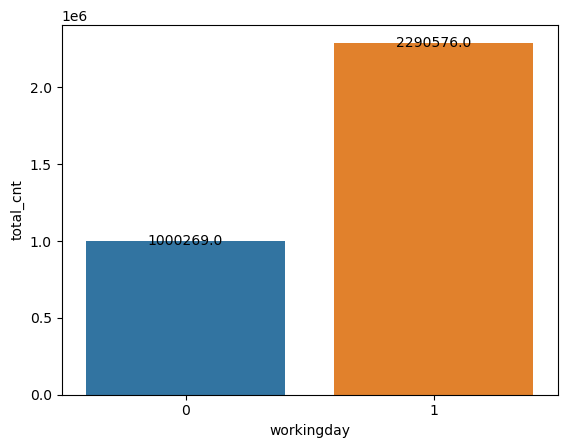

In [303]:
workday_cnt = bike.groupby('workingday')['cnt'].sum().reset_index(name='total_cnt')
#print(workday_cnt)
ax = sns.barplot(x=workday_cnt.workingday, y=workday_cnt['total_cnt'])
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center')
plt.show()

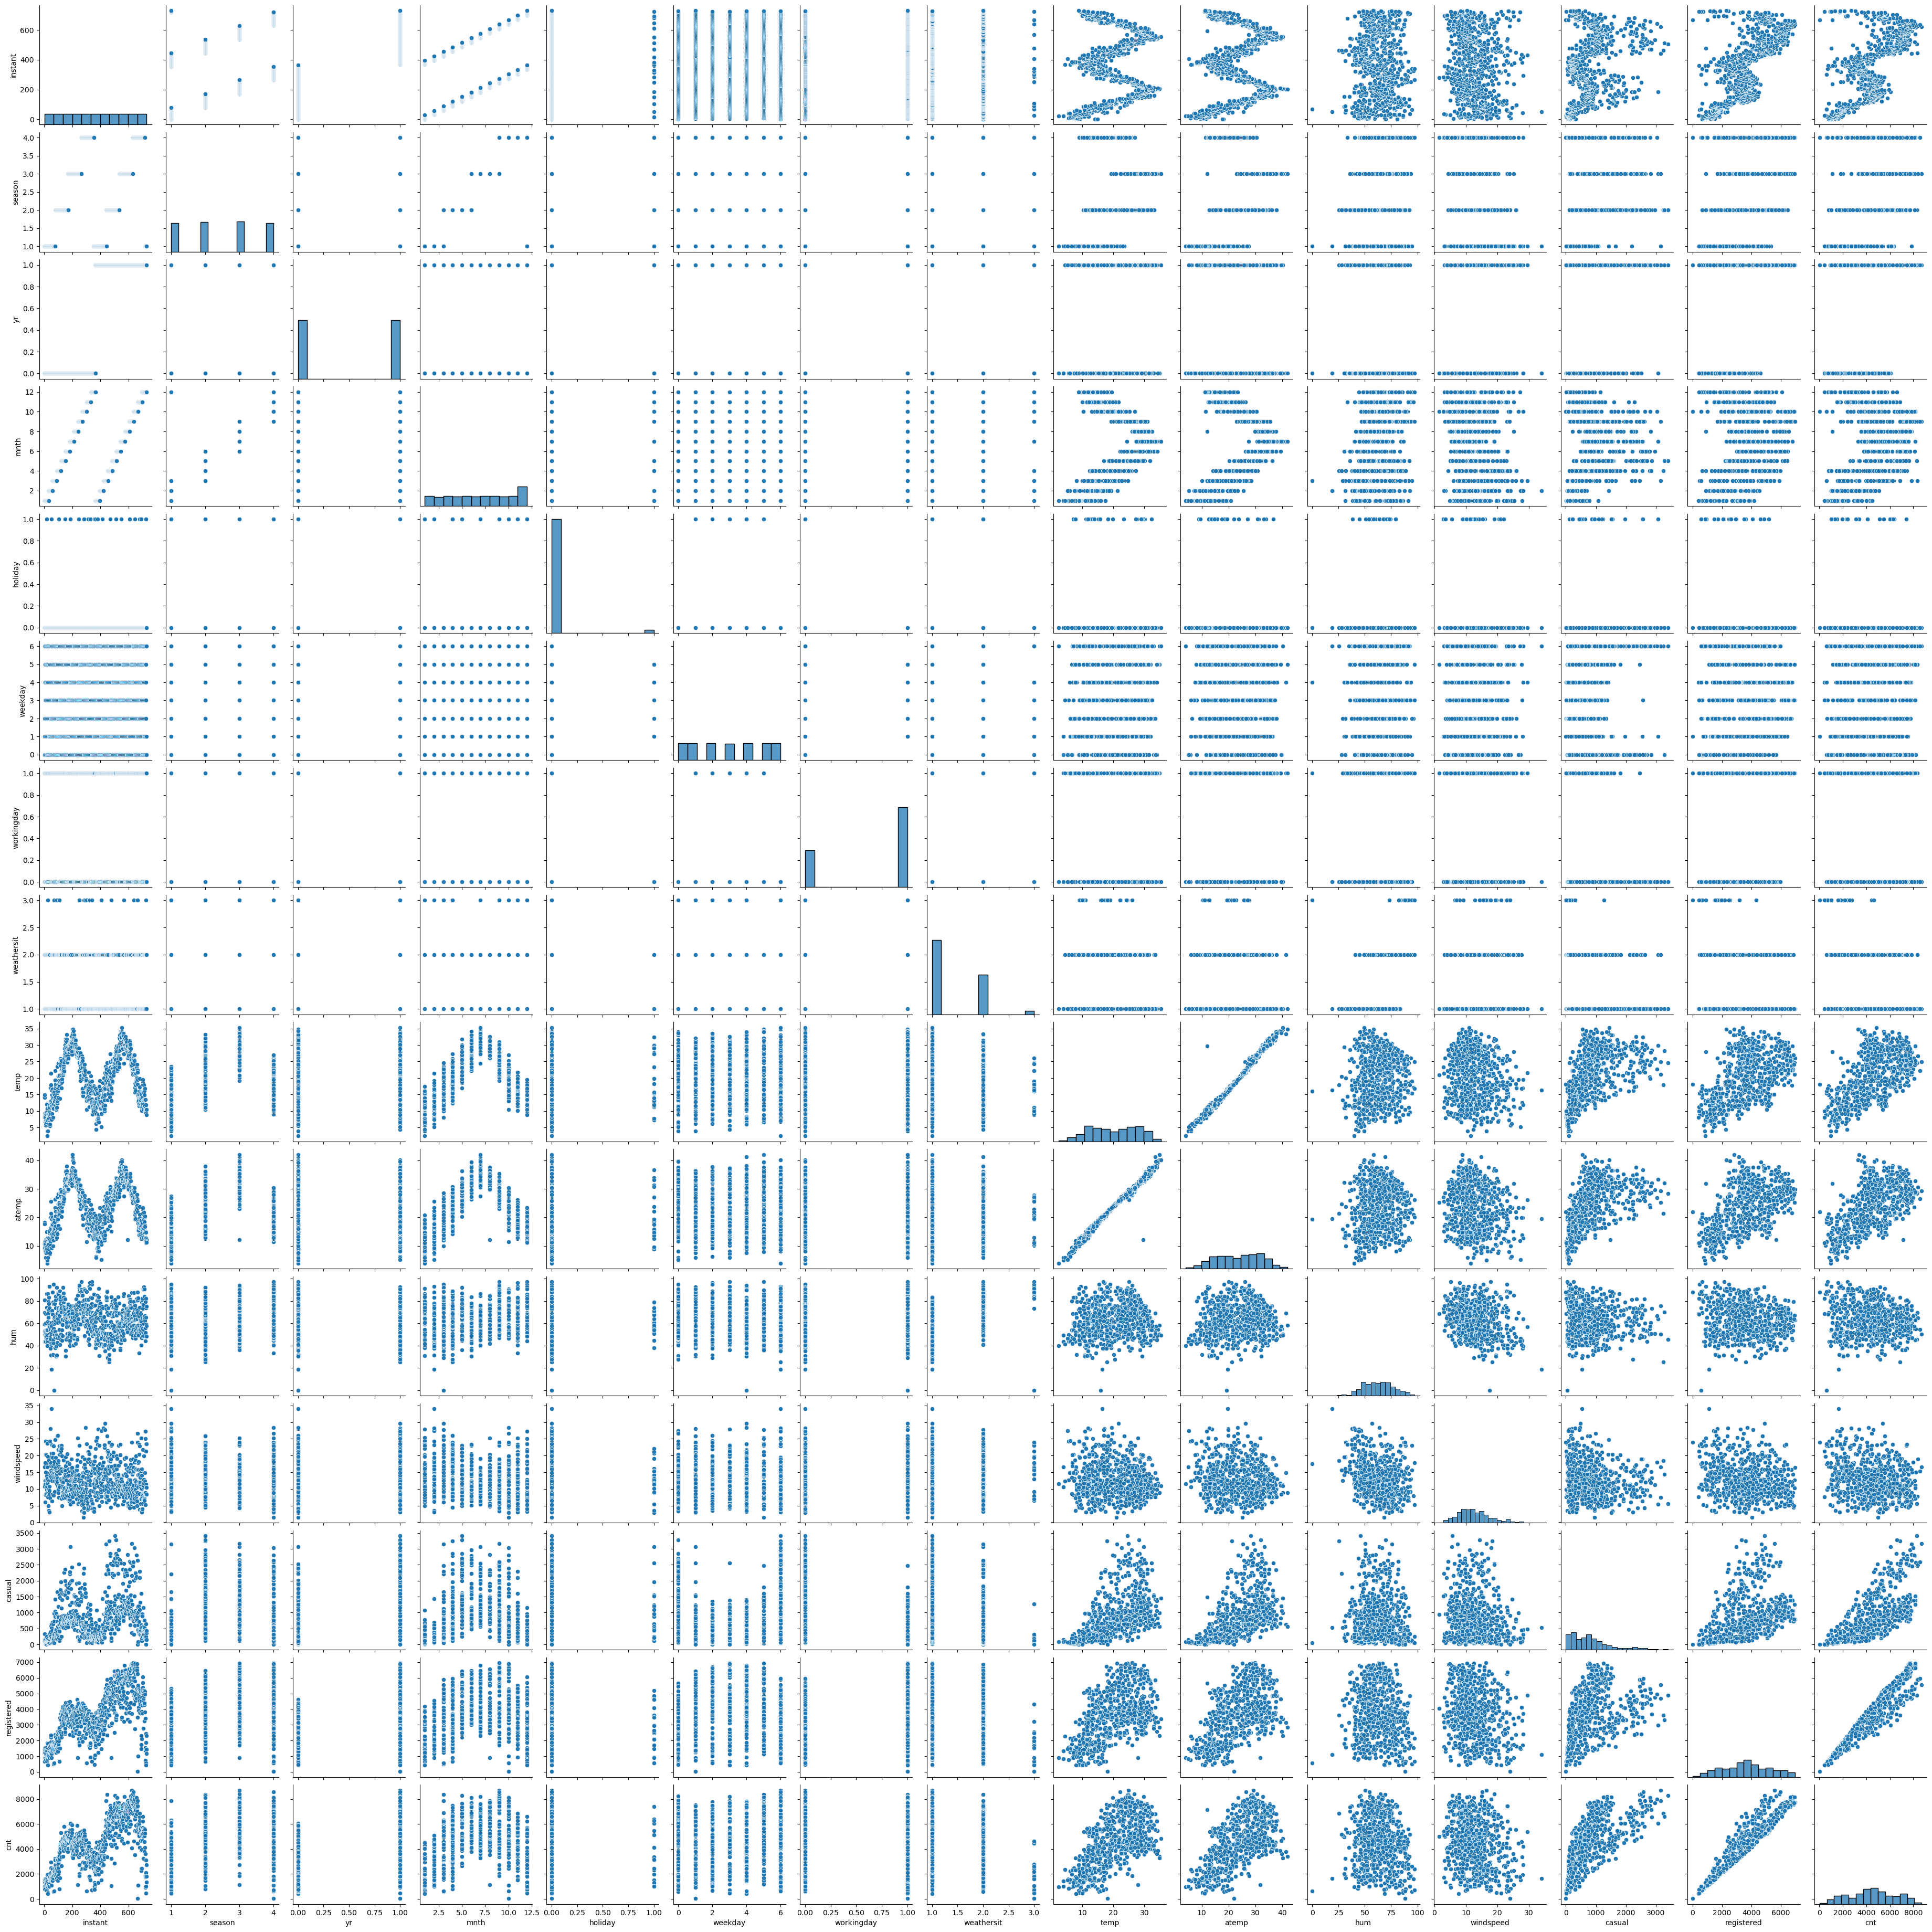

In [10]:
#Visualizaing the Numerical data
sns.pairplot(bike)
plt.show()

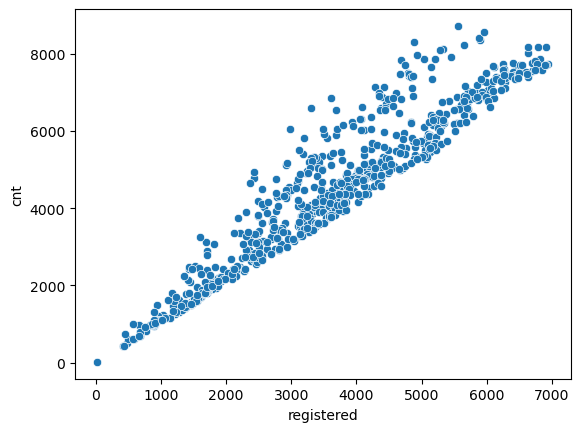

In [11]:
sns.scatterplot(bike.registered,bike.cnt)
plt.show()

In [304]:
bike.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

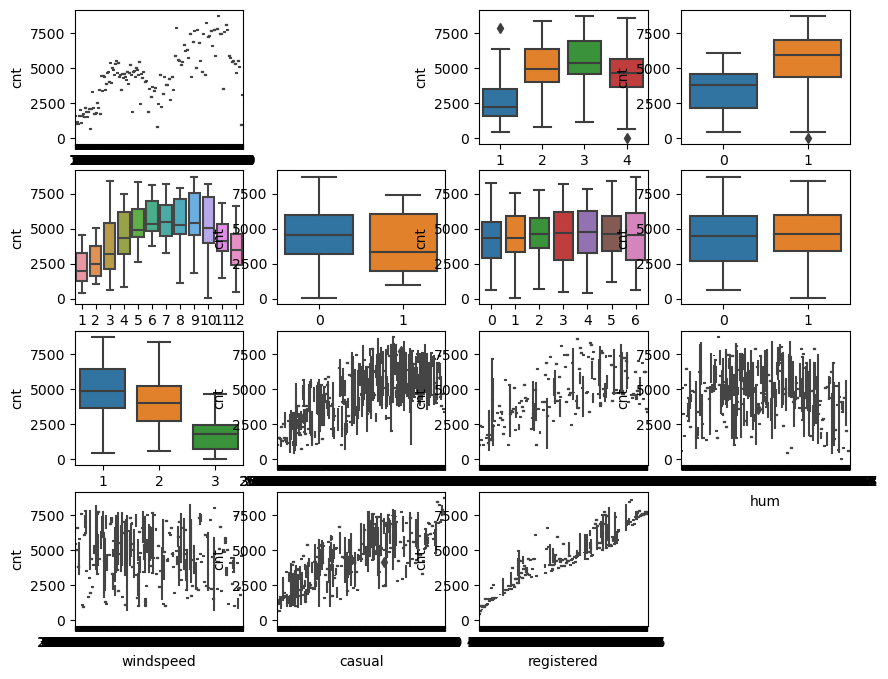

In [305]:
plt.figure(figsize=(10, 8))
plt.subplot(4,4,1)
sns.boxplot(x = 'instant', y = 'cnt', data = bike)
# plt.subplot(4,4,2)
# sns.boxplot(x = 'dteday', y = 'cnt', data = bike)
plt.subplot(4,4,3)
sns.boxplot(x = 'season', y = 'cnt', data = bike)
plt.subplot(4,4,4)
sns.boxplot(x = 'yr', y = 'cnt', data = bike)
plt.subplot(4,4,5)
sns.boxplot(x = 'mnth', y = 'cnt', data = bike)
plt.subplot(4,4,6)
sns.boxplot(x = 'holiday', y = 'cnt', data = bike)
plt.subplot(4,4,7)
sns.boxplot(x = 'weekday', y = 'cnt', data = bike)
plt.subplot(4,4,8)
sns.boxplot(x = 'workingday', y = 'cnt', data = bike)
plt.subplot(4,4,9)
sns.boxplot(x = 'weathersit', y = 'cnt', data = bike)
plt.subplot(4,4,10)
sns.boxplot(x = 'temp', y = 'cnt', data = bike)
plt.subplot(4,4,11)
sns.boxplot(x = 'atemp', y = 'cnt', data = bike)
plt.subplot(4,4,12)
sns.boxplot(x = 'hum', y = 'cnt', data = bike)
plt.subplot(4,4,13)
sns.boxplot(x = 'windspeed', y = 'cnt', data = bike)
plt.subplot(4,4,14)
sns.boxplot(x = 'casual', y = 'cnt', data = bike)
plt.subplot(4,4,15)
sns.boxplot(x = 'registered', y = 'cnt', data = bike)
plt.show()


In [25]:
#dropping the dteday column
bike = bike.drop(['instant','dteday'],axis = 1)
bike.head()

season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed  casual  registered   cnt  
0  18.18125  80.5833  10.749882     331         654   985  
1  17.68695  69.6087  16.652113     131         670   801  
2   9.47025  43.7273  16.636703     120        1229  1349  
3  10.60610  59.0435  10.739832     108        1454  1562  
4  11.46350  43.6957  12.522300      82        1518  1600

In [26]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  casual      730 non-null    int64  
 12  registered  730 non-null    int64  
 13  cnt         730 non-null    int64  
dtypes: float64(4), int64(10)
memory usage: 80.0 KB


In [92]:
# We specify this so that the train and test data set always have the same rows, respectively
df_train, df_test = train_test_split(bike, train_size = 0.7, random_state = 100)

In [93]:
print(df_train.shape)
print(df_test.shape)

(510, 14)
(220, 14)


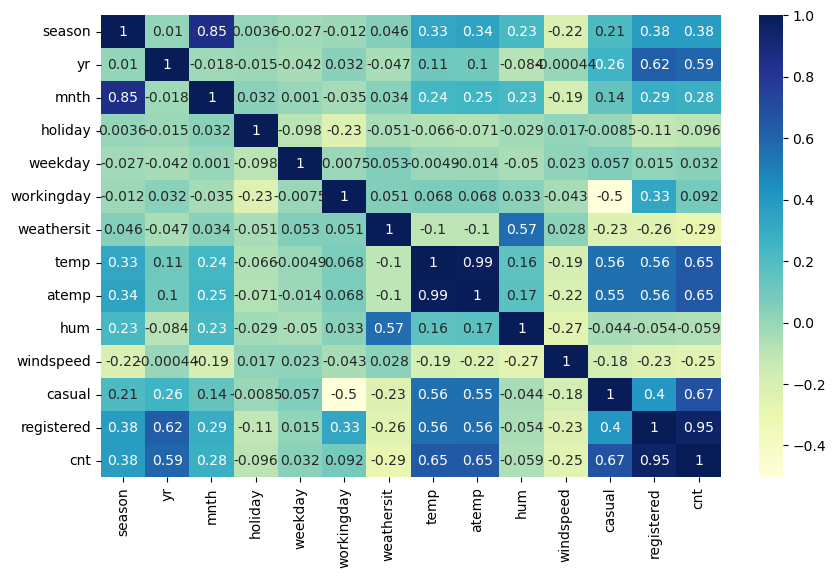

In [29]:
plt.figure(figsize=(10,6))
sns.heatmap(df_train.corr(),annot= True,cmap = "YlGnBu")
plt.show()

In [30]:
# removing the season because it has highly corellated with month
df_train = df_train.drop('season',axis = 1)
df_train.head()

yr  mnth  holiday  weekday  workingday  weathersit       temp    atemp  \
576   1     7        0        2           1           1  29.246653  33.1448   
426   1     3        0        6           0           2  16.980847  20.6746   
728   1    12        0        0           0           1  10.489153  11.5850   
482   1     4        0        6           0           2  15.443347  18.8752   
111   0     4        0        5           1           2  13.803347  16.0977   

         hum  windspeed  casual  registered   cnt  
576  70.4167  11.083475     968        6248  7216  
426  62.1250  10.792293     956        3110  4066  
728  48.3333  23.500518     364        1432  1796  
482  48.9583   8.708325    1120        3100  4220  
111  72.9583  14.707907     177        1506  1683

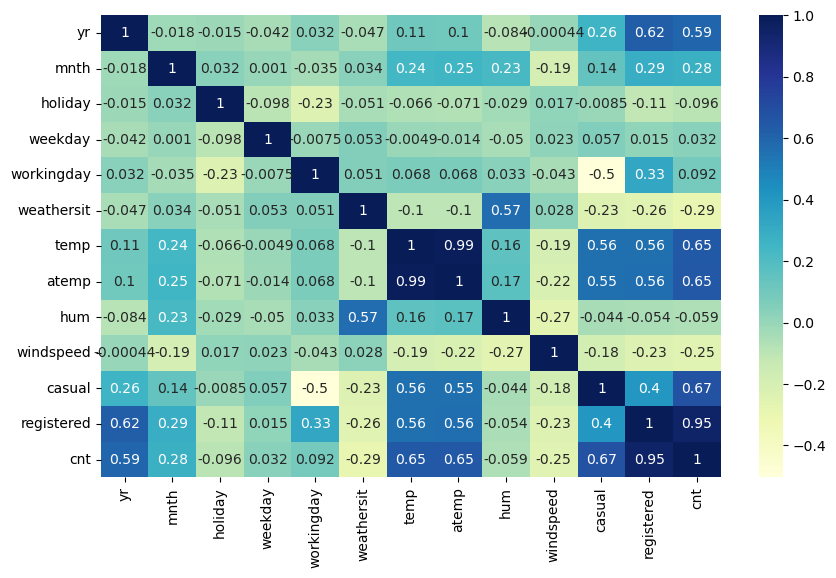

In [31]:
plt.figure(figsize=(10,6))
sns.heatmap(df_train.corr(),annot= True,cmap = "YlGnBu")
plt.show()

In [32]:
df_train.columns

Index(['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp',
       'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt'],
      dtype='object')

In [101]:
#initiating an object
scalar = MinMaxScaler()
#create a varlist
num_vars = ['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp',
       'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
#Fit the data
df_train[num_vars] =scalar.fit(df_train[num_vars])
df_train[num_vars] =scalar.transform(df_train[num_vars])
#df_train[num_vars] =scalar.fit_transform(df_train[num_vars])
df_train.head()

TypeError: float() argument must be a string or a number, not 'MinMaxScaler'

### Training The model

In [34]:
y_train  = df_train.pop('cnt')
X_train = df_train

In [35]:
print(X_train.shape)
print(y_train.shape)

(510, 12)
(510,)


### Building the statistics model

In [36]:
#Adding the constant
X_train_sm= sm.add_constant(X_train['registered'])
#Creating an object
lr = sm.OLS(y_train,X_train_sm)
#fit the model
model1 = lr.fit()
model1.params

const         0.024369
registered    0.933845
dtype: float64

In [37]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     4536.
Date:                Mon, 18 Sep 2023   Prob (F-statistic):          2.26e-255
Time:                        15:00:24   Log-Likelihood:                 624.25
No. Observations:                 510   AIC:                            -1244.
Df Residuals:                     508   BIC:                            -1236.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0244      0.008      3.077      0.002       0.009       0.040
registered     0.9338      0.014     67.350      0.000       0.907       0.961
==============================================================================
Omnibus:                      134.334   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              255.249
Skew:                           1.510   Prob(JB):                     3.74e-56
Kurtosis:                       4.699   Cond. No.                         5.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [100]:
y_pred = model1.predict(X_train_sm)

ValueError: shapes (510,5) and (2,) not aligned: 5 (dim 1) != 2 (dim 0)

In [39]:
res1 = y_train-y_pred

NameError: name 'y_pred' is not defined

In [ ]:
sns.distplot(res1)
plt.show()

In [ ]:
plt.scatter(res1,y_pred1)
plt.show()

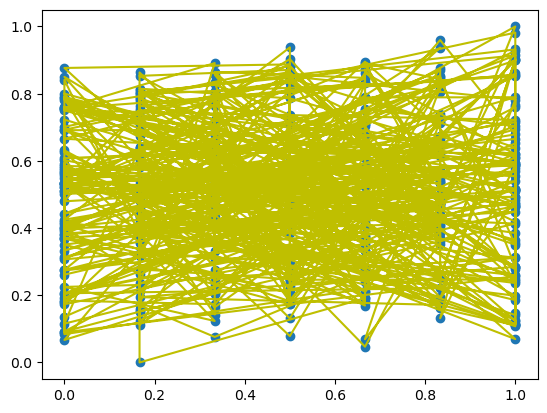

In [99]:
# Let's visualise the data with a scatter plot and the fitted regression line
plt.scatter(X_train_sm.iloc[:, 1], y_train)
#plt.plot(X_train_sm.iloc[:, 1], 0.024369 + 0.933845*X_train_sm.iloc[:, 1], 'y')
plt.plot(X_train_sm.iloc[:, 1],y_pred, 'y')
plt.show()

In [ ]:
#Adding the constant
X_train_sm= sm.add_constant(X_train)
#Creating an object
lr = sm.OLS(y_train,X_train_sm)
#fit the model
model = lr.fit()
model.params

In [41]:
model.summary()

NameError: name 'model' is not defined

In [42]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features     VIF
7        atemp  350.80
6         temp  335.62
11  registered   37.54
8          hum   16.51
4   workingday    9.89
10      casual    9.09
0           yr    5.45
1         mnth    5.01
9    windspeed    3.79
3      weekday    3.16
5   weathersit    2.58
2      holiday    1.12

In [43]:
X = X_train.drop('atemp',axis = 1)

In [44]:
X.head()

yr      mnth  holiday   weekday  workingday  weathersit      temp  \
576  1.0  0.545455      0.0  0.333333         1.0         0.0  0.815169   
426  1.0  0.181818      0.0  1.000000         0.0         0.5  0.442393   
728  1.0  1.000000      0.0  0.000000         0.0         0.0  0.245101   
482  1.0  0.272727      0.0  1.000000         0.0         0.5  0.395666   
111  0.0  0.272727      0.0  0.833333         1.0         0.5  0.345824   

          hum  windspeed    casual  registered  
576  0.725633   0.264686  0.294422    0.899220  
426  0.640189   0.255342  0.290765    0.446145  
728  0.498067   0.663106  0.110332    0.203869  
482  0.504508   0.188475  0.340750    0.444701  
111  0.751824   0.380981  0.053337    0.214554

In [45]:
#removed atemp feature and building the model for other variables
#Adding the constant
X_train_sm= sm.add_constant(X)
#Creating an object
lr = sm.OLS(y_train,X_train_sm)
#fit the model
model = lr.fit()
model.params

const        -1.387779e-17
yr           -2.480655e-16
mnth         -1.977585e-16
holiday       0.000000e+00
weekday      -2.220446e-16
workingday    1.665335e-16
weathersit    1.249001e-16
temp          3.191891e-16
hum           2.914335e-16
windspeed     8.326673e-17
casual        3.774735e-01
registered    7.968247e-01
dtype: float64

In [46]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.702e+31
Date:                Mon, 18 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:00:26   Log-Likelihood:                 17522.
No. Observations:                 510   AIC:                        -3.502e+04
Df Residuals:                     498   BIC:                        -3.497e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.388e-17    9.7e-17     -0.143      0.886   -2.04e-16    1.77e-16
yr         -2.481e-16   4.25e-17     -5.838      0.000   -3.32e-16   -1.65e-16
mnth       -1.978e-16    4.9e-17     -4.035      0.000   -2.94e-16   -1.01e-16
holiday             0   8.69e-17          0      1.000   -1.71e-16    1.71e-16
weekday     -2.22e-16   3.96e-17     -5.609      0.000      -3e-16   -1.44e-16
workingday  1.665e-16    5.1e-17      3.265      0.001    6.63e-17    2.67e-16
weathersit  1.249e-16   6.43e-17      1.942      0.053   -1.49e-18    2.51e-16
temp        3.192e-16   9.07e-17      3.520      0.000    1.41e-16    4.97e-16
hum         2.914e-16   1.22e-16      2.396      0.017    5.25e-17     5.3e-16
windspeed   8.327e-17   8.57e-17      0.972      0.332   -8.51e-17    2.52e-16
casual         0.3775   1.23e-16   3.08e+15      0.000       0.377       0.377
registered     0.7968   1.39e-16   5.72e+15      0.000       0.797       0.797
==============================================================================
Omnibus:                        7.597   Durbin-Watson:                   0.961
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                7.780
Skew:                           0.300   Prob(JB):                       0.0204
Kurtosis:                       2.915   Cond. No.                         23.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
10  registered  37.23
6         temp  16.42
7          hum  15.81
4   workingday   9.89
9       casual   9.09
0           yr   5.42
1         mnth   5.01
8    windspeed   3.73
3      weekday   3.15
5   weathersit   2.57
2      holiday   1.11

In [48]:
X = X.drop('holiday',axis = 1)

In [49]:
X.head()

yr      mnth   weekday  workingday  weathersit      temp       hum  \
576  1.0  0.545455  0.333333         1.0         0.0  0.815169  0.725633   
426  1.0  0.181818  1.000000         0.0         0.5  0.442393  0.640189   
728  1.0  1.000000  0.000000         0.0         0.0  0.245101  0.498067   
482  1.0  0.272727  1.000000         0.0         0.5  0.395666  0.504508   
111  0.0  0.272727  0.833333         1.0         0.5  0.345824  0.751824   

     windspeed    casual  registered  
576   0.264686  0.294422    0.899220  
426   0.255342  0.290765    0.446145  
728   0.663106  0.110332    0.203869  
482   0.188475  0.340750    0.444701  
111   0.380981  0.053337    0.214554

In [50]:
#removed atemp,ho;iday feature and building the model for other variables
#Adding the constant
X_train_sm= sm.add_constant(X)
#Creating an object
lr = sm.OLS(y_train,X_train_sm)
#fit the model
model = lr.fit()
model.params

const        -2.636780e-16
yr            2.983724e-16
mnth         -5.551115e-16
weekday       8.326673e-17
workingday    1.387779e-16
weathersit   -1.110223e-16
temp          7.632783e-17
hum           7.494005e-16
windspeed    -1.457168e-16
casual        3.774735e-01
registered    7.968247e-01
dtype: float64

In [51]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.214e+30
Date:                Mon, 18 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:00:26   Log-Likelihood:                 17194.
No. Observations:                 510   AIC:                        -3.437e+04
Df Residuals:                     499   BIC:                        -3.432e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.637e-16   1.83e-16     -1.445      0.149   -6.22e-16    9.49e-17
yr          2.984e-16   8.08e-17      3.693      0.000     1.4e-16    4.57e-16
mnth       -5.551e-16   9.32e-17     -5.956      0.000   -7.38e-16   -3.72e-16
weekday     8.327e-17   7.51e-17      1.109      0.268   -6.42e-17    2.31e-16
workingday  1.388e-16   9.43e-17      1.471      0.142   -4.66e-17    3.24e-16
weathersit  -1.11e-16   1.22e-16     -0.909      0.364   -3.51e-16    1.29e-16
temp        7.633e-17   1.72e-16      0.443      0.658   -2.62e-16    4.15e-16
hum         7.494e-16   2.31e-16      3.239      0.001    2.95e-16     1.2e-15
windspeed  -1.457e-16   1.63e-16     -0.894      0.372   -4.66e-16    1.74e-16
casual         0.3775    2.3e-16   1.64e+15      0.000       0.377       0.377
registered     0.7968   2.65e-16   3.01e+15      0.000       0.797       0.797
==============================================================================
Omnibus:                        9.542   Durbin-Watson:                   0.562
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                6.609
Skew:                           0.145   Prob(JB):                       0.0367
Kurtosis:                       2.524   Cond. No.                         23.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
9  registered  37.20
5        temp  16.37
6         hum  15.42
3  workingday   9.46
8      casual   8.91
0          yr   5.42
1        mnth   5.00
7   windspeed   3.71
2     weekday   3.14
4  weathersit   2.54

In [53]:
X= X.drop('temp',axis = 1)

In [54]:
#removed atemp,holiday,temp feature and building the model for other variables
#Adding the constant
X_train_sm= sm.add_constant(X)
#Creating an object
lr = sm.OLS(y_train,X_train_sm)
#fit the model
model = lr.fit()
model.params

const         3.469447e-17
yr            3.790371e-16
mnth          4.406198e-16
weekday       1.873501e-16
workingday    3.400058e-16
weathersit   -4.857226e-16
hum           6.938894e-16
windspeed    -2.775558e-17
casual        3.774735e-01
registered    7.968247e-01
dtype: float64

In [55]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.394e+30
Date:                Mon, 18 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:00:27   Log-Likelihood:                 16852.
No. Observations:                 510   AIC:                        -3.368e+04
Df Residuals:                     500   BIC:                        -3.364e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.469e-17   3.55e-16      0.098      0.922   -6.64e-16    7.33e-16
yr           3.79e-16   1.47e-16      2.584      0.010    9.08e-17    6.67e-16
mnth        4.406e-16   1.82e-16      2.423      0.016    8.34e-17    7.98e-16
weekday     1.874e-16   1.46e-16      1.283      0.200   -9.95e-17    4.74e-16
workingday    3.4e-16   1.82e-16      1.865      0.063   -1.83e-17    6.98e-16
weathersit -4.857e-16   2.38e-16     -2.039      0.042   -9.54e-16   -1.78e-17
hum         6.939e-16   4.43e-16      1.568      0.118   -1.76e-16    1.56e-15
windspeed  -2.776e-17   3.15e-16     -0.088      0.930   -6.47e-16    5.91e-16
casual         0.3775   4.01e-16   9.41e+14      0.000       0.377       0.377
registered     0.7968    4.8e-16   1.66e+15      0.000       0.797       0.797
==============================================================================
Omnibus:                       20.530   Durbin-Watson:                   0.128
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.885
Skew:                           0.491   Prob(JB):                     1.77e-05
Kurtosis:                       3.253   Cond. No.                         22.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
8  registered  32.17
5         hum  14.60
3  workingday   9.30
7      casual   7.14
1        mnth   4.99
0          yr   4.68
6   windspeed   3.66
2     weekday   3.11
4  weathersit   2.52

In [57]:
X = X.drop('windspeed',axis = 1)

In [58]:
#removed atemp,holiday,temp,windspeed feature and building the model for other variables
#Adding the constant
X_train_sm= sm.add_constant(X)
#Creating an object
lr = sm.OLS(y_train,X_train_sm)
#fit the model
model = lr.fit()
model.params

const         3.261280e-16
yr            1.040834e-16
mnth          2.775558e-17
weekday       3.261280e-16
workingday    3.955170e-16
weathersit    4.857226e-16
hum          -9.020562e-17
casual        3.774735e-01
registered    7.968247e-01
dtype: float64

In [59]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.256e+30
Date:                Mon, 18 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:00:28   Log-Likelihood:                 16806.
No. Observations:                 510   AIC:                        -3.359e+04
Df Residuals:                     501   BIC:                        -3.356e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.261e-16   3.14e-16      1.040      0.299    -2.9e-16    9.42e-16
yr          1.041e-16   1.59e-16      0.655      0.513   -2.08e-16    4.16e-16
mnth        2.776e-17   1.99e-16      0.140      0.889   -3.63e-16    4.18e-16
weekday     3.261e-16    1.6e-16      2.045      0.041    1.28e-17    6.39e-16
workingday  3.955e-16   1.99e-16      1.985      0.048    4.07e-18    7.87e-16
weathersit  4.857e-16   2.59e-16      1.878      0.061   -2.24e-17    9.94e-16
hum        -9.021e-17   4.63e-16     -0.195      0.846      -1e-15     8.2e-16
casual         0.3775   4.37e-16   8.63e+14      0.000       0.377       0.377
registered     0.7968    5.2e-16   1.53e+15      0.000       0.797       0.797
==============================================================================
Omnibus:                       33.737   Durbin-Watson:                   0.164
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.784
Skew:                           0.552   Prob(JB):                     1.25e-07
Kurtosis:                       2.474   Cond. No.                         22.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
7  registered  31.60
5         hum  12.85
3  workingday   9.11
6      casual   7.11
1        mnth   4.99
0          yr   4.52
2     weekday   2.98
4  weathersit   2.50

In [61]:
X = X.drop('hum',axis = 1)

In [62]:
#removed atemp,holiday,temp,windspeed,hum feature and building the model for other variables
#Adding the constant
X_train_sm= sm.add_constant(X)
#Creating an object
lr = sm.OLS(y_train,X_train_sm)
#fit the model
model = lr.fit()
model.params

const         1.195224e-15
yr            3.122502e-16
mnth         -1.353084e-16
weekday       5.620504e-16
workingday    8.673617e-16
weathersit   -1.332268e-15
casual        3.774735e-01
registered    7.968247e-01
dtype: float64

In [63]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.986e+29
Date:                Mon, 18 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:00:28   Log-Likelihood:                 16433.
No. Observations:                 510   AIC:                        -3.285e+04
Df Residuals:                     502   BIC:                        -3.282e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.195e-15   3.98e-16      3.000      0.003    4.12e-16    1.98e-15
yr          3.123e-16   3.27e-16      0.954      0.341   -3.31e-16    9.55e-16
mnth       -1.353e-16   4.06e-16     -0.334      0.739   -9.32e-16    6.62e-16
weekday     5.621e-16   3.29e-16      1.710      0.088   -8.36e-17    1.21e-15
workingday  8.674e-16   4.13e-16      2.098      0.036    5.51e-17    1.68e-15
weathersit -1.332e-15   4.38e-16     -3.040      0.002   -2.19e-15   -4.71e-16
casual         0.3775   9.06e-16   4.17e+14      0.000       0.377       0.377
registered     0.7968   1.08e-15    7.4e+14      0.000       0.797       0.797
==============================================================================
Omnibus:                       15.374   Durbin-Watson:                   0.149
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               15.762
Skew:                           0.406   Prob(JB):                     0.000378
Kurtosis:                       2.716   Cond. No.                         20.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
6  registered  31.51
3  workingday   8.10
5      casual   6.26
0          yr   4.52
1        mnth   4.40
2     weekday   2.83
4  weathersit   1.71

In [65]:
X = X.drop('mnth',axis = 1)

In [66]:
#removed atemp,holiday,temp,windspeed,hum,mnth feature and building the model for other variables
#Adding the constant
X_train_sm= sm.add_constant(X)
#Creating an object
lr = sm.OLS(y_train,X_train_sm)
#fit the model
model = lr.fit()
model.params

const         1.734723e-17
yr            9.627715e-17
weekday      -5.551115e-17
workingday   -4.163336e-17
weathersit    2.567391e-16
casual        3.774735e-01
registered    7.968247e-01
dtype: float64

In [67]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.799e+32
Date:                Mon, 18 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:00:29   Log-Likelihood:                 18039.
No. Observations:                 510   AIC:                        -3.606e+04
Df Residuals:                     503   BIC:                        -3.603e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.735e-17   1.63e-17      1.065      0.287   -1.47e-17    4.94e-17
yr          9.628e-17   1.29e-17      7.445      0.000    7.09e-17    1.22e-16
weekday    -5.551e-17   1.41e-17     -3.942      0.000   -8.32e-17   -2.78e-17
workingday -4.163e-17   1.67e-17     -2.487      0.013   -7.45e-17   -8.74e-18
weathersit  2.567e-16   1.83e-17     14.005      0.000    2.21e-16    2.93e-16
casual         0.3775   3.79e-17   9.95e+15      0.000       0.377       0.377
registered     0.7968   4.02e-17   1.98e+16      0.000       0.797       0.797
==============================================================================
Omnibus:                       12.048   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.398
Skew:                          -0.381   Prob(JB):                      0.00203
Kurtosis:                       3.048   Cond. No.                         17.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
5  registered  22.92
2  workingday   7.64
4      casual   6.18
0          yr   3.84
1     weekday   2.81
3  weathersit   1.52

In [69]:
X = X.drop('workingday',axis= 1)

In [70]:
#removed atemp,holiday,temp,windspeed,hum,mnth,workingday feature and building the model for other variables
#Adding the constant
X_train_sm= sm.add_constant(X)
#Creating an object
lr = sm.OLS(y_train,X_train_sm)
#fit the model
model = lr.fit()
model.params

const         1.266348e-16
yr           -1.214306e-16
weekday      -2.428613e-16
weathersit    2.220446e-16
casual        3.774735e-01
registered    7.968247e-01
dtype: float64

In [71]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.242e+31
Date:                Mon, 18 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:00:31   Log-Likelihood:                 17364.
No. Observations:                 510   AIC:                        -3.472e+04
Df Residuals:                     504   BIC:                        -3.469e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.266e-16   5.76e-17      2.200      0.028    1.35e-17     2.4e-16
yr         -1.214e-16   4.56e-17     -2.665      0.008   -2.11e-16   -3.19e-17
weekday    -2.429e-16   5.28e-17     -4.600      0.000   -3.47e-16   -1.39e-16
weathersit   2.22e-16   6.83e-17      3.253      0.001    8.79e-17    3.56e-16
casual         0.3775   9.47e-17   3.99e+15      0.000       0.377       0.377
registered     0.7968   1.07e-16   7.44e+15      0.000       0.797       0.797
==============================================================================
Omnibus:                        9.609   Durbin-Watson:                   0.641
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                7.449
Skew:                           0.197   Prob(JB):                       0.0241
Kurtosis:                       2.558   Cond. No.                         9.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
4  registered  6.86
0          yr  3.27
3      casual  3.03
1     weekday  2.75
2  weathersit  1.41

In [73]:
X = X.drop('yr',axis =1)

In [74]:
#removed atemp,holiday,temp,windspeed,hum,mnth,workingday,yr feature and building the model for other variables
#Adding the constant
X_train_sm= sm.add_constant(X)
#Creating an object
lr = sm.OLS(y_train,X_train_sm)
#fit the model
model = lr.fit()
model.params

const        -2.099015e-16
weekday       2.775558e-16
weathersit   -3.261280e-16
casual        3.774735e-01
registered    7.968247e-01
dtype: float64

In [75]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.556e+31
Date:                Mon, 18 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:00:33   Log-Likelihood:                 17331.
No. Observations:                 510   AIC:                        -3.465e+04
Df Residuals:                     505   BIC:                        -3.463e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.099e-16   6.02e-17     -3.485      0.001   -3.28e-16   -9.16e-17
weekday     2.776e-16   5.62e-17      4.939      0.000    1.67e-16    3.88e-16
weathersit -3.261e-16    7.2e-17     -4.530      0.000   -4.68e-16   -1.85e-16
casual         0.3775   1.01e-16   3.74e+15      0.000       0.377       0.377
registered     0.7968   9.17e-17   8.69e+15      0.000       0.797       0.797
==============================================================================
Omnibus:                        5.968   Durbin-Watson:                   0.291
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                4.018
Skew:                          -0.019   Prob(JB):                        0.134
Kurtosis:                       2.567   Cond. No.                         7.87
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [76]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
3  registered  4.12
2      casual  3.03
0     weekday  2.67
1  weathersit  1.40

In [77]:
y_pred = model.predict(X_train_sm)

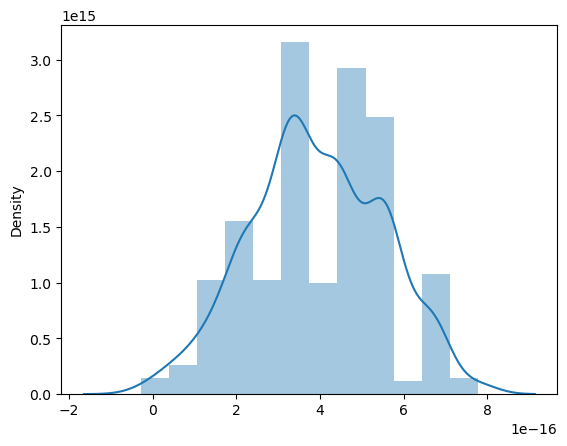

In [78]:
res = y_train - y_pred
sns.distplot(res)
plt.show()

In [79]:
# plt.scatter(X_train,Y_train)
# #plt.plot(X_train,6.9487+0.0545*X_train,'r')
# plt.plot(X_train,y_pred,'r')
# plt.show()

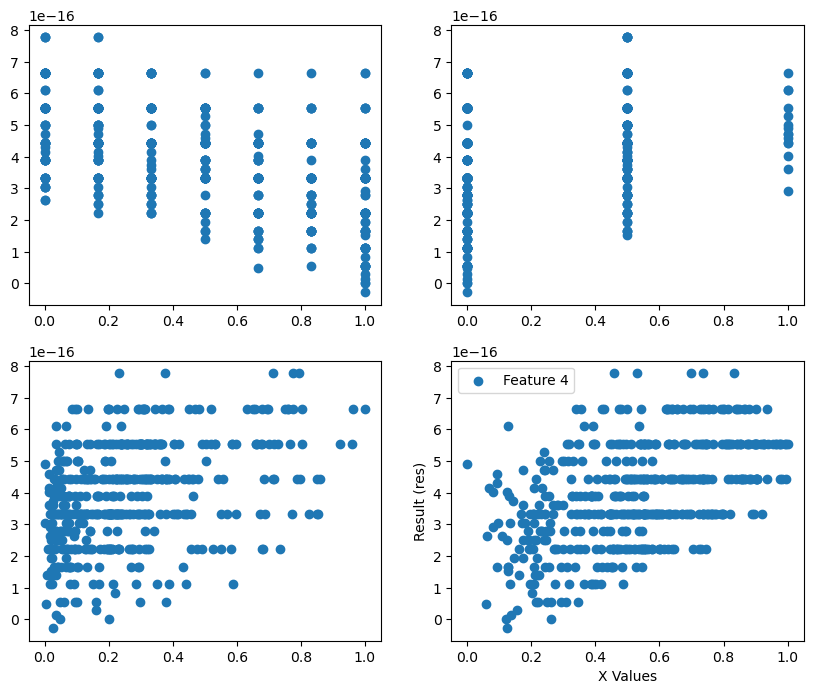

In [80]:

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.subplot(2,2,1)
plt.scatter(X.iloc[:, 0], res, label='Feature 1')
plt.subplot(2,2,2)
plt.scatter(X.iloc[:, 1], res, label='Feature 2')
plt.subplot(2,2,3)
plt.scatter(X.iloc[:, 2], res, label='Feature 3')
plt.subplot(2,2,4)
plt.scatter(X.iloc[:, 3], res, label='Feature 4')

# Add labels and legend
plt.xlabel('X Values')
plt.ylabel('Result (res)')
plt.legend()

# Show the plot
plt.show()


## Evaluating the test data

In [94]:
df_test.head()

season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
184       3   0     7        1        1           0           2  29.793347   
535       2   1     6        0        3           1           1  32.082500   
299       4   0    10        0        4           1           2  19.270000   
221       3   0     8        0        3           1           1  31.433347   
152       2   0     6        0        4           1           1  29.315000   

        atemp      hum  windspeed  casual  registered   cnt  
184  33.27085  63.7917   5.459106    3065        2978  6043  
535  36.04875  59.2083   7.625404     872        5339  6211  
299  22.85230  81.2917  13.250121     240        2419  2659  
221  34.24915  42.4167  13.417286     884        3896  4780  
152  32.19710  30.5000  19.583229     736        4232  4968

In [82]:
print(len(df_test.index))

220


In [98]:
#initiating an object
scalar = MinMaxScaler()
#create a varlist
num_vars = ['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp',
       'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
#Fit the data
df_test[num_vars] =scalar.transform(df_test[num_vars])
df_test.head()

NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [84]:
X_test = df_test[['weekday','weathersit','casual','registered']]
y_test = df_test.pop('cnt')

In [85]:
X_test.head()

weekday  weathersit    casual  registered
184  0.166667         0.5  0.898559    0.397068
535  0.500000         0.0  0.253749    0.765284
299  0.666667         0.5  0.067921    0.309888
221  0.500000         0.0  0.257277    0.540237
152  0.666667         0.0  0.213761    0.592639

In [86]:
y_test.head()

184    0.704300
535    0.725421
299    0.278853
221    0.545512
152    0.569148
Name: cnt, dtype: float64

In [87]:
# Adding constant variable to test dataframe
X_test_m = sm.add_constant(X_test)
#Predict on test data
y_pred_test = model.predict(X_test_m)

In [88]:
# r2 score
r2_score(y_test,y_pred_test)

0.9923333867187307

In [89]:
r1_score = r2_score(y_train,y_pred)
r1_score

1.0

In [383]:
#Mean squared error
print(mean_squared_error(y_train,y_pred))
print(mean_squared_error(y_test,y_pred_test))

1.784739460270358e-31
0.0004377533064811394


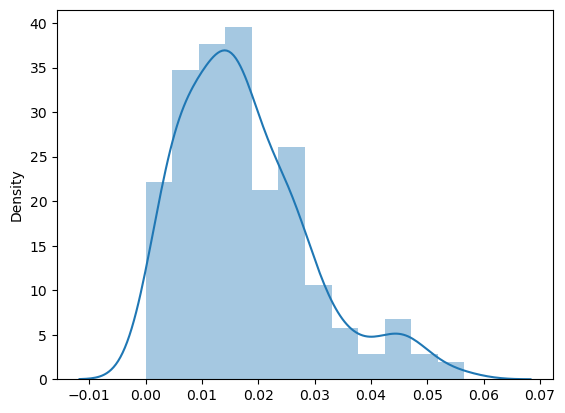

In [421]:
res = y_test - y_pred_test
sns.distplot(res)
plt.show()

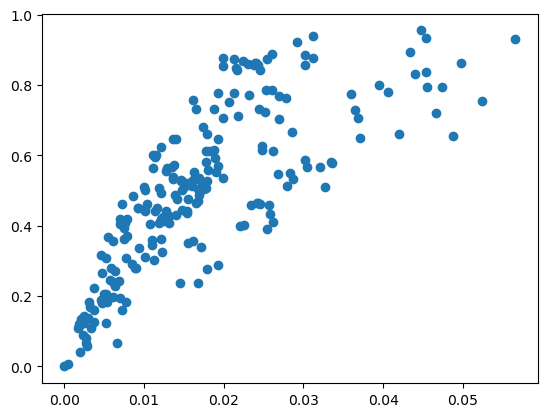

In [424]:
plt.scatter(res,y_pred_test)
#plt.scatter(X_train_sm.iloc[:,4],res)
#plt.plot(X_train,6.9487+0.0545*X_train,'r')
#plt.plot(y_test,y_pred_test,'r')
plt.show()

In [419]:
len(res)

510

### Building the model using sci_kit learn

In [165]:
bike_new  = bike

In [167]:
bike_new.head()

season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed  casual  registered   cnt  
0  18.18125  80.5833  10.749882     331         654   985  
1  17.68695  69.6087  16.652113     131         670   801  
2   9.47025  43.7273  16.636703     120        1229  1349  
3  10.60610  59.0435  10.739832     108        1454  1562  
4  11.46350  43.6957  12.522300      82        1518  1600

In [13]:
#initiating an object
scalar = MinMaxScaler()
#create a varlist
num_vars = ['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp',
       'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
#Fit the data
bike_new[num_vars] =scalar.transform(bike_new[num_vars])
bike_new.head()

NameError: name 'MinMaxScaler' is not defined

In [170]:
X = bike_new[['weekday','weathersit','casual','registered']]
y = bike_new['cnt']

In [171]:
#Train _test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.70,random_state = 100)

In [174]:
# Steps In Sklear_model Buiding
# 1. create object for linear regression
lm = LinearRegression()
# 2.fit the model
lm.fit(X_train,y_train)

LinearRegression()

In [175]:
# 3.see the param, make predictons
print(lm.coef_)
print(lm.intercept_)


[ 7.31891283e-17 -2.90717870e-16  3.92084676e-01  7.96824666e-01]
1.1102230246251565e-16


In [176]:
# 4. Evaluate model(r2_score,etc..)
y_test_pred = lm.predict(X_test)
y_train_pred = lm.predict(X_train)

In [177]:
print("test predictions:",r2_score(y_test,y_test_pred))
print("train predictions:",r2_score(y_train,y_train_pred))

test predictions: 1.0
train predictions: 1.0


In [179]:
print("test predictions Error:",mean_squared_error(y_test,y_test_pred))
print("train predictions Error:",mean_squared_error(y_train,y_train_pred))

test predictions Error: 1.0094936888046095e-32
train predictions Error: 1.0926035394957825e-32
